In [1]:
import os
import re
import time
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

In [2]:
import cellregmap 
cellregmap 

<module 'cellregmap' from '/hps/nobackup/stegle/users/acuomo/git_repos/CellRegMap/cellregmap/__init__.py'>

In [3]:
from cellregmap import run_interaction

In [4]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [7]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [8]:
############################################
################ Kinship matrix ############
############################################

In [9]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [10]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [11]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [12]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [13]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [14]:
############################################
##### expand from donors to cells ##########

In [15]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [16]:
######################################
############### Genotypes ############
######################################

In [17]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:33<00:00, 131.21s/it]


In [18]:
######################################
########## Cell contexts #############
######################################

In [20]:
# cells by LDVAE (10)
# C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/20PCs.csv"
C_file = "/hps/nobackup/stegle/users/mjbonder/Anna/zinbwave_20.tsv"
C = pd.read_csv(C_file, index_col = 0, sep="\t")
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [21]:
# quantile normalise cell contexts
C1 = C
C1_gauss = quantile_gaussianize(C1)

In [22]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [23]:
# quantile normalise cell contexts
C2 = C
C2_gauss = quantile_gaussianize(C2)

In [24]:
import matplotlib.pyplot as plt

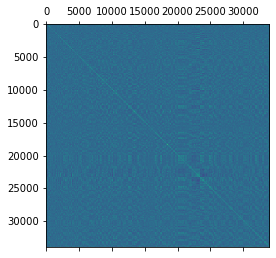

In [25]:
plt.matshow(C1.values @ C1.values.T)

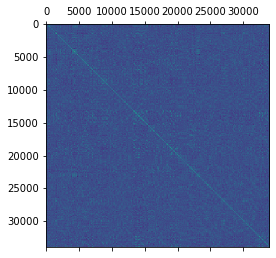

In [26]:
plt.matshow(C2.values @ C2.values.T)

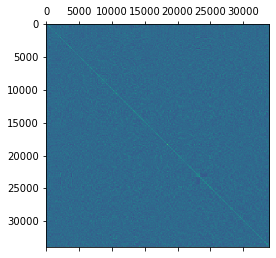

In [27]:
plt.matshow(C1_gauss.values @ C1_gauss.values.T)

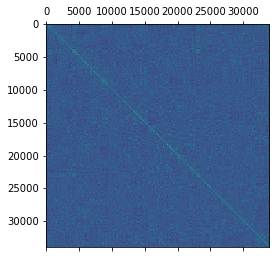

In [28]:
plt.matshow(C2_gauss.values @ C2_gauss.values.T)

In [29]:
#####################################
############ Phenotypes #############
#####################################

In [30]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [31]:
#####################################
############ Filter file ############
#####################################

In [32]:
# filter file (columns: snp_id, gene)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
endo_eqtl.head(2)

,snp_id,feature,stage,chrom
0,5_149826526_C_T,ENSG00000164587_RPS14,ips,5
1,11_57283988_C_T,ENSG00000134809_TIMM10,ips,11


In [33]:
chrom = 22
# and consider eGenes on that chromosome
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [34]:
len(genes)

88

In [35]:
genes

array(['ENSG00000100058_CRYBB2P1', 'ENSG00000184674_GSTT1',
       'ENSG00000196236_XPNPEP3', 'ENSG00000189306_RRP7A',
       'ENSG00000100410_PHF5A', 'ENSG00000093072_CECR1',
       'ENSG00000099974_DDTL', 'ENSG00000100033_PRODH',
       'ENSG00000179750_APOBEC3B', 'ENSG00000099984_GSTT2',
       'ENSG00000100429_HDAC10', 'ENSG00000100122_CRYBB1',
       'ENSG00000133433_GSTT2B', 'ENSG00000128283_CDC42EP1',
       'ENSG00000099942_CRKL', 'ENSG00000215012_C22orf29',
       'ENSG00000100422_CERK', 'ENSG00000100376_FAM118A',
       'ENSG00000099940_SNAP29', 'ENSG00000100417_PMM1',
       'ENSG00000075234_TTC38', 'ENSG00000211643_IGLV5-52',
       'ENSG00000099977_DDT', 'ENSG00000128191_DGCR8',
       'ENSG00000100413_POLR3H', 'ENSG00000185339_TCN2',
       'ENSG00000128294_TPST2', 'ENSG00000185838_GNB1L',
       'ENSG00000184983_NDUFA6', 'ENSG00000185651_UBE2L3',
       'ENSG00000100243_CYB5R3', 'ENSG00000169314_C22orf15',
       'ENSG00000244509_APOBEC3C', 'ENSG00000100347_SAMM50',
    

In [42]:
column_names = ['chrom','gene','pv','variant']
pv = pd.DataFrame(columns = column_names)
pv.head()

,chrom,gene,pv,variant


In [43]:
for gene_name in genes:
    trait_name = re.sub("_.*","",gene_name)
    leads = endo_eqtl[endo_eqtl['feature']==gene_name]['snp_id'].unique()
    G_sel = G[:,G['snp'].isin(leads)]
    G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
    assert all(hK_expanded.sample.values == G_expanded.sample.values)
    y = phenotype.sel(trait=gene_name)
    y = quantile_gaussianize(y)
    y = y.values.reshape(y.shape[0],1)
    n_cells = phenotype.shape[1]
    W = ones((n_cells, 1))
    GG = G_expanded.values
    print("Running for gene {}".format(gene_name))
    pvals = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
    pv_curr = pd.DataFrame({"chrom":G_expanded.chrom.values,
           "gene":gene_name,
           "pv":pvals,
           "variant":G_expanded.snp.values})
    pv = pd.concat([pv, pv_curr])

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100058_CRYBB2P1


100%|██████████| 2/2 [04:45<00:00, 142.60s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000184674_GSTT1


100%|██████████| 1/1 [02:15<00:00, 135.24s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000196236_XPNPEP3


100%|██████████| 2/2 [05:17<00:00, 158.58s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000189306_RRP7A


100%|██████████| 3/3 [07:02<00:00, 140.85s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100410_PHF5A


100%|██████████| 3/3 [07:29<00:00, 149.79s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000093072_CECR1


100%|██████████| 2/2 [05:05<00:00, 152.65s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099974_DDTL


100%|██████████| 3/3 [07:40<00:00, 153.41s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100033_PRODH


100%|██████████| 2/2 [04:43<00:00, 141.87s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000179750_APOBEC3B


100%|██████████| 2/2 [04:40<00:00, 140.30s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099984_GSTT2


100%|██████████| 2/2 [04:43<00:00, 141.91s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100429_HDAC10


100%|██████████| 2/2 [05:14<00:00, 157.26s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100122_CRYBB1


100%|██████████| 1/1 [02:24<00:00, 144.76s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000133433_GSTT2B


100%|██████████| 3/3 [07:04<00:00, 141.36s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128283_CDC42EP1


100%|██████████| 1/1 [02:25<00:00, 145.70s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099942_CRKL


100%|██████████| 1/1 [02:24<00:00, 144.22s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000215012_C22orf29


100%|██████████| 1/1 [02:33<00:00, 153.86s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100422_CERK


100%|██████████| 3/3 [07:18<00:00, 146.17s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100376_FAM118A


100%|██████████| 2/2 [04:56<00:00, 148.04s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099940_SNAP29


100%|██████████| 1/1 [02:32<00:00, 152.80s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100417_PMM1


100%|██████████| 1/1 [02:26<00:00, 146.38s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000075234_TTC38


100%|██████████| 1/1 [02:32<00:00, 152.22s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000211643_IGLV5-52


100%|██████████| 3/3 [07:50<00:00, 156.91s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099977_DDT


100%|██████████| 2/2 [04:43<00:00, 141.51s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128191_DGCR8


100%|██████████| 2/2 [04:50<00:00, 145.38s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100413_POLR3H


100%|██████████| 1/1 [02:21<00:00, 141.64s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000185339_TCN2


100%|██████████| 1/1 [02:15<00:00, 135.95s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128294_TPST2


100%|██████████| 2/2 [04:36<00:00, 138.25s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000185838_GNB1L


100%|██████████| 1/1 [02:30<00:00, 150.05s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000184983_NDUFA6


100%|██████████| 1/1 [02:24<00:00, 144.90s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000185651_UBE2L3


100%|██████████| 1/1 [02:15<00:00, 135.01s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100243_CYB5R3


100%|██████████| 2/2 [04:41<00:00, 140.84s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000169314_C22orf15


100%|██████████| 1/1 [02:25<00:00, 145.32s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000244509_APOBEC3C


100%|██████████| 2/2 [04:27<00:00, 133.98s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100347_SAMM50


100%|██████████| 1/1 [02:18<00:00, 138.61s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100292_HMOX1


100%|██████████| 1/1 [02:27<00:00, 147.13s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099991_CABIN1


100%|██████████| 1/1 [02:28<00:00, 148.63s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100196_KDELR3


100%|██████████| 1/1 [02:24<00:00, 144.78s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100083_GGA1


100%|██████████| 1/1 [02:34<00:00, 154.77s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000183628_DGCR6


100%|██████████| 1/1 [02:25<00:00, 145.31s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000133422_MORC2


100%|██████████| 2/2 [04:31<00:00, 135.99s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100097_LGALS1


100%|██████████| 1/1 [02:19<00:00, 139.97s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100299_ARSA


100%|██████████| 2/2 [05:10<00:00, 155.12s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100258_LMF2


100%|██████████| 1/1 [02:28<00:00, 148.22s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100321_SYNGR1


100%|██████████| 2/2 [04:47<00:00, 143.77s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100362_PVALB


100%|██████████| 1/1 [02:27<00:00, 147.38s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000184979_USP18


100%|██████████| 1/1 [02:21<00:00, 141.24s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100263_RHBDD3


100%|██████████| 2/2 [04:40<00:00, 140.15s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100304_TTLL12


100%|██████████| 1/1 [02:24<00:00, 144.89s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000184949_FAM227A


100%|██████████| 1/1 [02:35<00:00, 155.99s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000198951_NAGA


100%|██████████| 1/1 [02:33<00:00, 153.74s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100330_MTMR3


100%|██████████| 1/1 [02:44<00:00, 164.28s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000077942_FBLN1


100%|██████████| 2/2 [04:34<00:00, 137.40s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000177663_IL17RA


100%|██████████| 1/1 [02:29<00:00, 149.94s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000219438_FAM19A5


100%|██████████| 1/1 [02:22<00:00, 142.35s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100380_ST13


100%|██████████| 1/1 [02:26<00:00, 146.01s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000167065_DUSP18


100%|██████████| 1/1 [02:39<00:00, 159.73s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000185133_INPP5J


100%|██████████| 1/1 [02:25<00:00, 145.61s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099995_SF3A1


100%|██████████| 1/1 [02:19<00:00, 139.88s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128394_APOBEC3F


100%|██████████| 2/2 [04:51<00:00, 145.75s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100027_YPEL1


100%|██████████| 1/1 [02:28<00:00, 148.56s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000184117_NIPSNAP1


100%|██████████| 1/1 [02:30<00:00, 150.75s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100311_PDGFB


100%|██████████| 1/1 [02:27<00:00, 147.59s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100242_SUN2


100%|██████████| 1/1 [02:39<00:00, 159.05s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100234_TIMP3


100%|██████████| 1/1 [02:23<00:00, 143.02s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100416_TRMU


100%|██████████| 1/1 [02:23<00:00, 143.37s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100124_ANKRD54


100%|██████████| 1/1 [02:36<00:00, 156.93s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000214076_CPSF1P1


100%|██████████| 2/2 [04:43<00:00, 141.56s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000196419_XRCC6


100%|██████████| 1/1 [02:14<00:00, 134.85s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000196576_PLXNB2


100%|██████████| 1/1 [02:22<00:00, 142.33s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100345_MYH9


100%|██████████| 1/1 [02:24<00:00, 144.86s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000187860_CCDC157


100%|██████████| 1/1 [02:44<00:00, 164.39s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100344_PNPLA3


100%|██████████| 2/2 [04:57<00:00, 148.89s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128185_DGCR6L


100%|██████████| 1/1 [02:28<00:00, 148.75s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100031_GGT1


100%|██████████| 1/1 [02:31<00:00, 151.24s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100241_SBF1


100%|██████████| 1/1 [02:31<00:00, 151.45s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000183864_TOB2


100%|██████████| 1/1 [02:21<00:00, 141.25s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000099949_LZTR1


100%|██████████| 1/1 [02:31<00:00, 151.14s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100162_CENPM


100%|██████████| 1/1 [02:19<00:00, 139.96s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000198089_SFI1


100%|██████████| 1/1 [02:34<00:00, 154.11s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000189060_H1F0


100%|██████████| 1/1 [02:24<00:00, 144.14s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000183569_SERHL2


100%|██████████| 1/1 [02:17<00:00, 137.92s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000198355_PIM3


100%|██████████| 1/1 [02:30<00:00, 150.43s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000185022_MAFF


100%|██████████| 1/1 [02:42<00:00, 162.88s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100038_TOP3B


100%|██████████| 1/1 [02:38<00:00, 158.56s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100206_DMC1


100%|██████████| 1/1 [02:41<00:00, 161.86s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100290_BIK


100%|██████████| 1/1 [02:38<00:00, 158.32s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100316_RPL3


100%|██████████| 1/1 [02:16<00:00, 136.18s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000100201_DDX17


100%|██████████| 1/1 [02:25<00:00, 145.58s/it]


In [44]:
pv.head()

,chrom,gene,pv,variant
0,22,ENSG00000100058_CRYBB2P1,0.001059,22_25845855_C_G
1,22,ENSG00000100058_CRYBB2P1,0.001897,22_25924999_G_A
0,22,ENSG00000184674_GSTT1,0.000075,22_24295427_C_T
0,22,ENSG00000196236_XPNPEP3,0.000045,22_41256802_A_G
1,22,ENSG00000196236_XPNPEP3,0.101570,22_41394128_C_T


In [45]:
pv.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_int_ZINB-WaVE/summary_new.csv")

In [46]:
len(pv['gene'].unique())

88

In [47]:
pv['gene'].unique()

array(['ENSG00000100058_CRYBB2P1', 'ENSG00000184674_GSTT1',
       'ENSG00000196236_XPNPEP3', 'ENSG00000189306_RRP7A',
       'ENSG00000100410_PHF5A', 'ENSG00000093072_CECR1',
       'ENSG00000099974_DDTL', 'ENSG00000100033_PRODH',
       'ENSG00000179750_APOBEC3B', 'ENSG00000099984_GSTT2',
       'ENSG00000100429_HDAC10', 'ENSG00000100122_CRYBB1',
       'ENSG00000133433_GSTT2B', 'ENSG00000128283_CDC42EP1',
       'ENSG00000099942_CRKL', 'ENSG00000215012_C22orf29',
       'ENSG00000100422_CERK', 'ENSG00000100376_FAM118A',
       'ENSG00000099940_SNAP29', 'ENSG00000100417_PMM1',
       'ENSG00000075234_TTC38', 'ENSG00000211643_IGLV5-52',
       'ENSG00000099977_DDT', 'ENSG00000128191_DGCR8',
       'ENSG00000100413_POLR3H', 'ENSG00000185339_TCN2',
       'ENSG00000128294_TPST2', 'ENSG00000185838_GNB1L',
       'ENSG00000184983_NDUFA6', 'ENSG00000185651_UBE2L3',
       'ENSG00000100243_CYB5R3', 'ENSG00000169314_C22orf15',
       'ENSG00000244509_APOBEC3C', 'ENSG00000100347_SAMM50',
    